## New York Taxi Trip Duration EDA (Kaggle)

Kaggle URL: https://www.kaggle.com/c/nyc-taxi-trip-duration

This notebook presents my (relatively simple) approach to apply XGBOOST to the given dataset and my attempt to dive into the errors and fix them. The latter step was done in light of label leaks that occurred in the Kaggle forum.

We start with loading the modules:

In [29]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.cluster import KMeans
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean
import pickle
import warnings
warnings.filterwarnings('ignore')

In [6]:
raw_train = pd.read_csv('original/train.csv')
raw_test = pd.read_csv('original/test.csv')

First we combine the test and train sets and have a look at the content:

In [8]:
df = pd.concat([raw_train, raw_test], axis = 0)
df.columns.tolist()

['dropoff_datetime',
 'dropoff_latitude',
 'dropoff_longitude',
 'id',
 'passenger_count',
 'pickup_datetime',
 'pickup_latitude',
 'pickup_longitude',
 'store_and_fwd_flag',
 'trip_duration',
 'vendor_id']

Have a look at the datatypes of the columns then:

In [9]:
[(x, df[x].dtype) for x in df.columns]

[('dropoff_datetime', dtype('O')),
 ('dropoff_latitude', dtype('float64')),
 ('dropoff_longitude', dtype('float64')),
 ('id', dtype('O')),
 ('passenger_count', dtype('int64')),
 ('pickup_datetime', dtype('O')),
 ('pickup_latitude', dtype('float64')),
 ('pickup_longitude', dtype('float64')),
 ('store_and_fwd_flag', dtype('O')),
 ('trip_duration', dtype('float64')),
 ('vendor_id', dtype('int64'))]

First problem here is that the datetime columns are just objects. Fix it with the following:

In [11]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

We can now extract the datetime features and expand our feature set:

In [12]:
for x in ['pickup_datetime', 'dropoff_datetime']:
    df[x.replace('datetime', 'month')] = df[x].dt.month
    df[x.replace('datetime', 'weekday')] = df[x].dt.weekday
    df[x.replace('datetime', 'day')] = df[x].dt.day
    df[x.replace('datetime', 'hour')] = df[x].dt.hour
    df[x.replace('datetime', 'minute')] = df[x].dt.minute

Dataset seems to be clean enough for EDA now, let's start with plotting the map for every pair of pickup and dropoff coordinates:

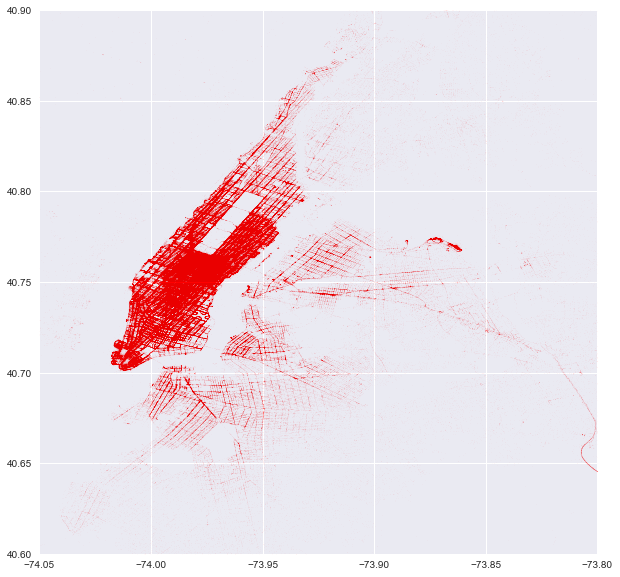

In [24]:
plt.figure(figsize = (10, 10))
all_coords = np.vstack((df[['pickup_longitude', 'pickup_latitude']], df[['dropoff_longitude', 'dropoff_latitude']]))
plt.plot(all_coords[:, 0], all_coords[:, 1], 'r.', markersize = 0.2)
plt.xlim([-74.05, -73.8])
plt.ylim([40.6, 40.9])
plt.show()

Now we take a step backwards a have a look at the distribution of the variables (which will be very important later on with modelling):

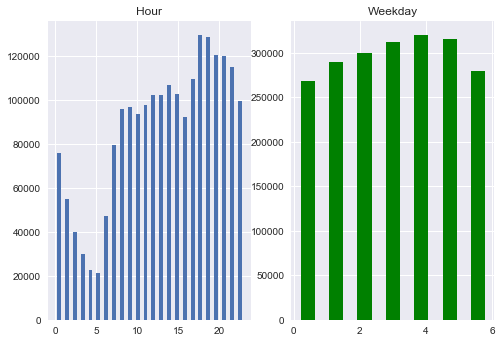

In [27]:
fig, ax = plt.subplots(1, 2)
ax[0].hist(df['pickup_hour'], bins = 24, rwidth = 0.5)
ax[0].set_title('Hour')
ax[1].hist(df['pickup_weekday'], bins = 7, rwidth = 0.5, color = 'g')
ax[1].set_title('Weekday')
plt.show()

The histograms show us a reasonable distribution of trips over Hour and Weekday with a visible pattern to be modelled.
We can then look at the trip duration:

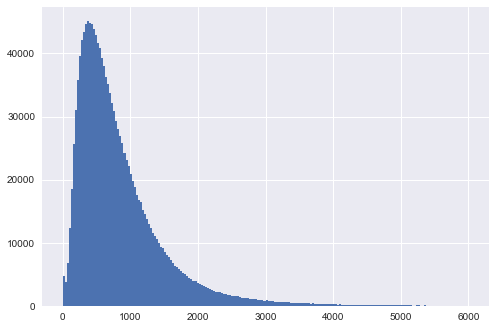

In [36]:
plt.figure()
plt.hist(df['trip_duration'], bins = 200, range = [0, 6000])
plt.show()


Kinda skewed. We can log-transform it to see what happens. We actually need that because Kaggle only counts RMSLE.

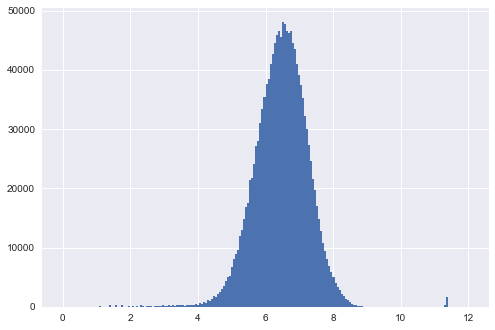

In [41]:
df['log_trip_duration'] = np.log(df['trip_duration'] + 1)
plt.figure()
plt.hist(df['log_trip_duration'], bins = 200, range = [0, 12])
plt.show()

Beautifully the bell shape I wanted. We can see that little bump at about x = 11, that will turn out to be a huge problem but let's leave that aside for now.
We want to know more about the average speed, but before that we have to figure a way to calculate distance. There are people using external data for it we will stick to straight line distance here:

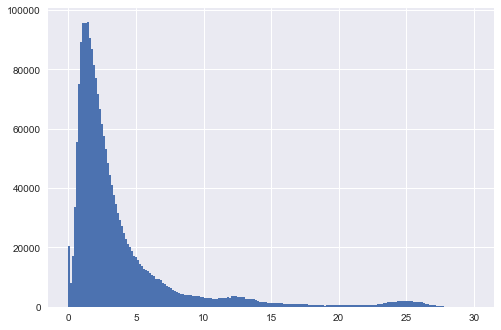

In [49]:
## CALCULATE DISTANCE ON A GLOBE
def arrays_haversine(lats1, lngs1, lats2, lngs2, R=6371):
    lats_delta_rads = np.radians(lats2 - lats1)
    lngs_delta_rads = np.radians(lngs2 - lngs1)
    a = np.sin(lats_delta_rads / 2)**2 + np.cos(lats1) * np.cos(lats2) * np.sin(lngs_delta_rads / 2)**2
    c = 2 * np.arcsin(a**0.5)
    return(R * c)

df['haversine'] = arrays_haversine(df['pickup_latitude'], 
                                       df['pickup_longitude'],
                                       df['dropoff_latitude'], 
                                       df['dropoff_longitude'])

df['avg_speed'] = df['haversine'] / df['trip_duration']

plt.figure()
plt.hist(df['haversine'], bins = 200, range = [0,30])
plt.show()

Pretty slow, but keep in mind that we are talking about averaged straight line distance.
Next we look at the distribution of trip duration against other variables:

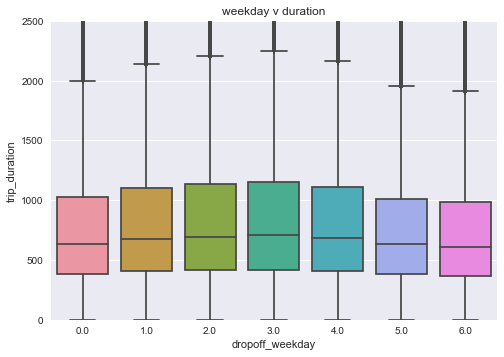

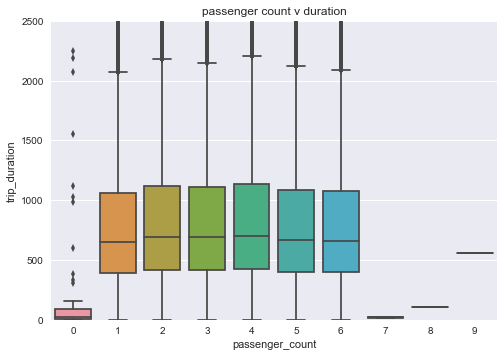

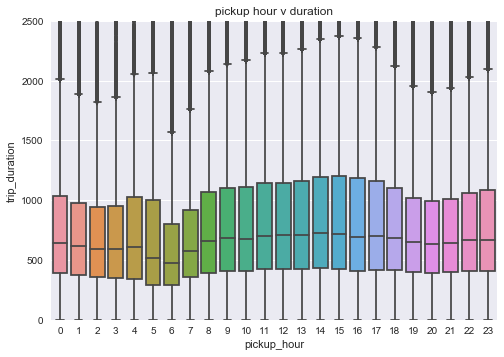

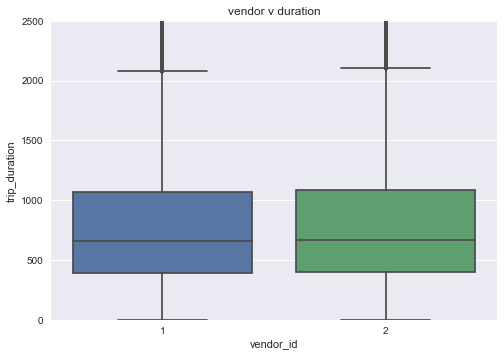

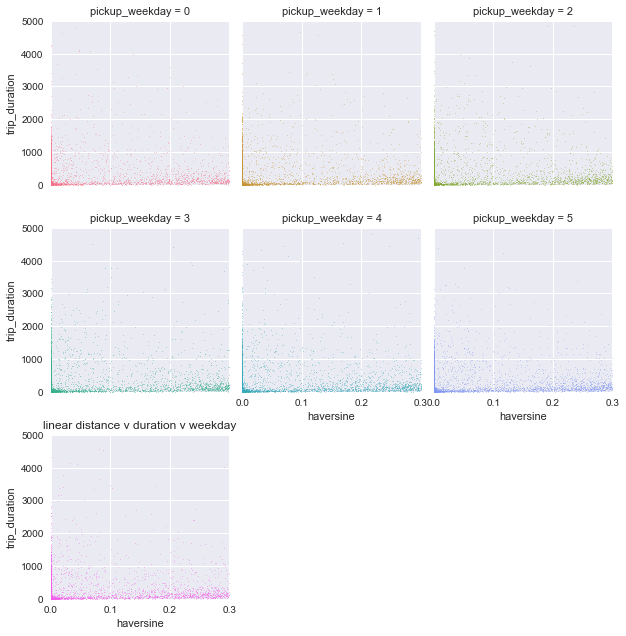

In [55]:
plt.figure()
sns.boxplot(data = df, x = 'dropoff_weekday', y = 'trip_duration')
plt.ylim([0, 2500])
plt.title('weekday v duration')
plt.show()

plt.figure()
sns.boxplot(data = df, x = 'passenger_count', y = 'trip_duration')
plt.ylim([0, 2500])
plt.title('passenger count v duration')
df.groupby('passenger_count')['id'].count()
plt.show()

plt.figure()
sns.boxplot(data = df, x = 'pickup_hour', y = 'trip_duration')
plt.ylim([0, 2500])
plt.title('pickup hour v duration')
plt.show()

plt.figure()
sns.boxplot(data = df, x = 'vendor_id', y = 'trip_duration')
plt.ylim([0, 2500])
plt.title('vendor v duration')
plt.show()

grid = sns.FacetGrid(df, col = "pickup_weekday", hue = 'pickup_weekday', col_wrap = 3)
grid.map(plt.scatter, 'haversine', 'trip_duration', s = 0.1)
grid.set(xlim = (0, 0.3), ylim = (0, 5000))
plt.title('linear distance v duration v weekday')
plt.show()

We also want to cluster our coordinates. Selection of n in KMeans is discretionary but one can use the elbow method (learnt from Andrew Ng). It takes forever to load so I will just load from a pickle here:

In [56]:
# def clustering(df, n_):
    
#     train_pickup = np.insert(np.array(df[['pickup_latitude', 'pickup_longitude']]), 2, 1, axis = 1)
#     train_dropoff = np.insert(np.array(df[['dropoff_latitude', 'dropoff_longitude']]), 2, 0, axis = 1)
#     train_clust = np.append(train_pickup, train_dropoff, axis = 0)[:, [0, 1]]
    
#     ## POOR MAN"S METHOD
#     train_clust = train_clust[np.random.choice(train_clust.shape[0], 600000, replace=False)]
    
#     print('Running KMeans clustering with n_center =', n_)
#     cluster = KMeans(n_clusters = n_).fit(train_clust)
    
#     pickle.dump(cluster, open('./cluster_analysis/cluster.p', 'wb'))
    
#     return(cluster)


load_clust = pickle.load(open('./cluster_analysis/cluster.p', 'rb'))
df['pickup_zone'] = load_clust.predict(df[['pickup_latitude', 'pickup_longitude']])
df['dropoff_zone'] = load_clust.predict(df[['dropoff_latitude', 'dropoff_longitude']])

Now we can plot the map iteratively zone by zone:

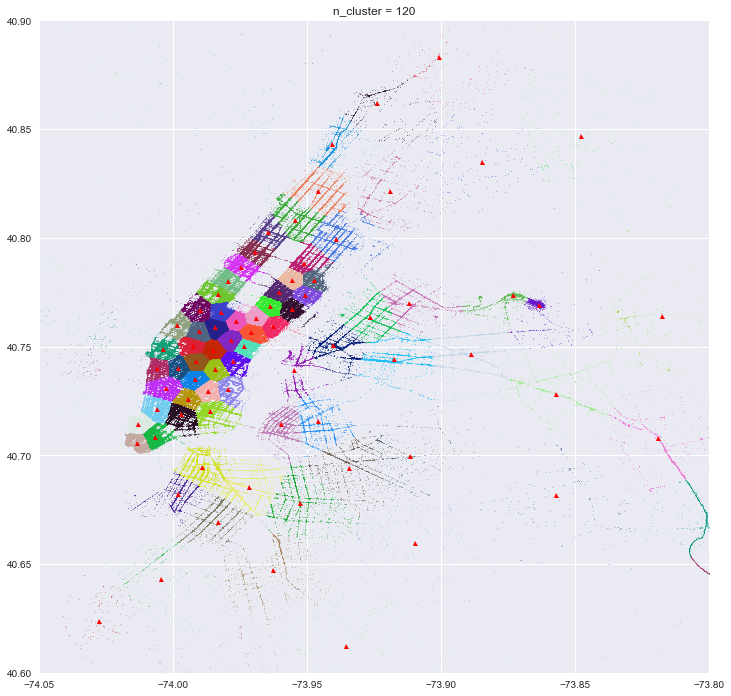

In [61]:
def draw_cluster(clust, df):
    
    ## zip cluster coordinates
    x, y= zip(*clust.cluster_centers_)
    grp = len(x)
    
    ## PLOT SCATTER FOR EVERY ZONE
    plt.figure(figsize = (12,12))
    for i in range(grp):
        lon = df[df['pickup_zone'] == i]['pickup_longitude']
        lat = df[df['pickup_zone'] == i]['pickup_latitude']
        plt.plot(lon, lat, marker = '.', linestyle = '', c = np.random.rand(3,), alpha = 0.9, markersize = 1, label = str(i))
        
    plt.plot(list(y), list(x), c = 'r', marker = '^', linestyle = '', alpha = 1, markersize = 5)
    plt.xlim([-74.05, -73.8])
    plt.ylim([40.6, 40.9])
    plt.title('n_cluster = ' + str(grp))
    plt.show()
draw_cluster(load_clust, df)

In [ ]:
This concludes the EDA.